<a href="https://colab.research.google.com/github/s0han24/NA_RLPSO/blob/main/NA_RL_PSO_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install torch torchvision scikit-learn scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [6]:
%pip install tqdm

In [7]:
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import load_digits, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [8]:
import itertools

In [9]:
# Define objective function to minimize (Rastrigin function)
def rastrigin(x):
    A = 10
    return A * len(x) + sum([(xi ** 2 - A * np.cos(2 * np.pi * xi)) for xi in x])

In [42]:
# Particle Swarm Optimization implementation (baseline)
class Particle:
    def __init__(self, dim, bounds, objective=rastrigin, random_sequence=None):
        # replace random with some sequence for experimentation
        if random_sequence is not None:
            self.position = random_sequence
        else:
            self.position = np.array([random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        self.best_value = objective(self.position)

class PSO:
    def __init__(self, dim, bounds, num_particles=30, num_iter=100, objective=rastrigin, random_sequences=None):
        self.dim = dim
        self.bounds = bounds
        self.num_particles = num_particles
        self.num_iter = num_iter
        self.objective = objective
        if random_sequences is None:
            self.swarm = [Particle(dim, bounds, objective) for _ in range(num_particles)]
        else :
            self.swarm = [Particle(dim, bounds, objective, random_sequence) for random_sequence in random_sequences]
        self.global_best_position = np.copy(self.swarm[0].position)
        self.global_best_value = objective(self.global_best_position)
        self.history_X = []
        self.history_V = []
        self.history_results = []

    def optimize(self):
        w = 0.5
        c1, c2 = 1.5, 1.5
        X = [particle.position for particle in self.swarm]
        V = [particle.velocity for particle in self.swarm]
        self.history_X.append(X)
        self.history_V.append(V)
        self.history_results.append(self.global_best_value)
        for _ in range(self.num_iter):
            X = []
            V = []
            for particle in self.swarm:
                r1, r2 = random.random(), random.random()
                particle.velocity = (w * particle.velocity +
                                     c1 * r1 * (particle.best_position - particle.position) +
                                     c2 * r2 * (self.global_best_position - particle.position))
                particle.position = np.clip(particle.position + particle.velocity, self.bounds[:, 0], self.bounds[:, 1])
                value = self.objective(particle.position)
                X.append(particle.position)
                V.append(particle.velocity)
                if value < particle.best_value:
                    particle.best_position, particle.best_value = particle.position, value
                if value < self.global_best_value:
                    self.global_best_position, self.global_best_value = particle.position, value
            self.history_X.append(X)
            self.history_V.append(V)
            self.history_results.append(self.global_best_value)
        return self.global_best_position, self.global_best_value, self.history_X, self.history_V, self.history_results

In [43]:
# Policy Network for the RL component
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=16):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.action_mean = nn.Linear(hidden_size, action_dim)
        # Learnable log_std parameter for the Gaussian distribution
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = self.action_mean(x)
        std = torch.exp(self.log_std)
        return mean, std

    def select_action(self, state):
        mean, std = self.forward(state)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()  # Sum log probabilities across dimensions
        # Clamp actions to a plausible range for c1 and c2 (e.g., [1.0, 2.0])
        action = torch.clamp(action, 1.0, 2.0)
        return action, log_prob

# RL-enhanced PSO using the policy network to select acceleration coefficients c1 and c2
class RLPSO(PSO):
    def __init__(self, dim, bounds, num_particles=30, num_iter=100, objective=rastrigin, lr=1e-2, random_sequences=None):
        super().__init__(dim, bounds, num_particles, num_iter, objective, random_sequences)
        # Define a simple state: [iteration_ratio, global_best_value]
        self.state_dim = 2
        self.action_dim = 2  # one for c1 and one for c2
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.objective = objective
        self.history_X = []
        self.history_V = []
        self.history_results = []

    def get_state(self, iteration):
        # Normalize iteration to [0, 1]
        iter_norm = iteration / self.num_iter
        # Use the current global best value (optionally, further normalization can be applied)
        state = np.array([iter_norm, self.global_best_value], dtype=np.float32)
        return torch.tensor(state)

    def optimize(self):
        w = 0.5

        X = [particle.position for particle in self.swarm]
        V = [particle.velocity for particle in self.swarm]
        self.history_X.append(X)
        self.history_V.append(V)
        self.history_results.append(self.global_best_value)

        for it in tqdm(range(1, self.num_iter + 1), desc="Training progress"):
            state = self.get_state(it)
            action, log_prob = self.policy_net.select_action(state)
            c1, c2 = action.detach().numpy()  # use the selected coefficients for this iteration
            X = []
            V = []
            # Store the old global best for reward computation
            old_global_best = self.global_best_value
            for particle in self.swarm:
                r1, r2 = random.random(), random.random()
                particle.velocity = (w * particle.velocity +
                                     c1 * r1 * (particle.best_position - particle.position) +
                                     c2 * r2 * (self.global_best_position - particle.position))
                particle.position = np.clip(particle.position + particle.velocity, self.bounds[:,0], self.bounds[:,1])
                value = self.objective(particle.position)
                X.append(particle.position)
                V.append(particle.velocity)
                if value < particle.best_value:
                    particle.best_position, particle.best_value = particle.position, value
                if value < self.global_best_value:
                    self.global_best_position, self.global_best_value = particle.position, value
            self.history_X.append(X)
            self.history_V.append(V)
            self.history_results.append(self.global_best_value)

            # Reward: improvement in global best value
            reward = old_global_best - self.global_best_value
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            # Update policy network using the REINFORCE rule: maximize reward
            loss = -log_prob * reward_tensor
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return self.global_best_position, self.global_best_value, self.history_X, self.history_V, self.history_results


In [12]:
# Testing both the baseline PSO and the RL-enhanced PSO
dim = 2
bounds = np.array([[-2,2] for _ in range(dim)])
num_particles = 40
num_iter = 30

# generate num_particles number of random sequences of length dim each
random_sequences = [np.array([random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)]) for _ in range(num_particles)]


print("Running baseline PSO...")
pso_solver = PSO(dim, bounds, num_particles, num_iter, random_sequences=random_sequences)
best_position_pso, best_value_pso, X_list_pso, V_list_pso, pso_results = pso_solver.optimize()
print("\nBaseline PSO solution:")
print("Best position:", best_position_pso)
print("Best value:", best_value_pso)

print("\nRunning RL-enhanced PSO (RLPSO)...")
rl_pso_solver = RLPSO(dim, bounds, num_particles, num_iter, random_sequences=random_sequences)
best_position_rl, best_value_rl, X_list, V_list, rl_pso_results = rl_pso_solver.optimize()
print("\nRLPSO solution:")
print("Best position:", best_position_rl)
print("Best value:", best_value_rl)

Running baseline PSO...

Baseline PSO solution:
Best position: [0.00031708 0.00110744]
Best value: 0.0002632554577601809

Running RL-enhanced PSO (RLPSO)...


Training progress: 100%|██████████| 30/30 [00:00<00:00, 65.42it/s]


RLPSO solution:
Best position: [ 7.26893824e-06 -8.93395422e-06]
Best value: 2.6317309220758034e-08


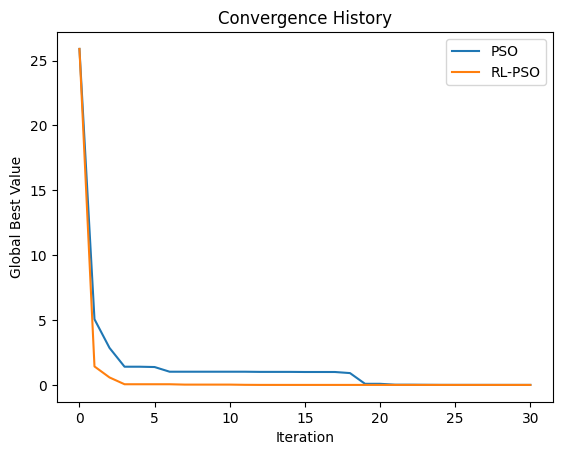

In [13]:
# prompt: plot the history from the pso algorithms

import matplotlib.pyplot as plt

# Plot the history of the global best value for both PSO algorithms
plt.plot(pso_results, label='PSO')
plt.plot(rl_pso_results, label='RL-PSO')
plt.xlabel('Iteration')
plt.ylabel('Global Best Value')
plt.title('Convergence History')
plt.legend()
plt.show()


In [14]:
%pip install scikit-opt

## Training some simple models to test hyperparameter tuning capabilities

#### Model 1: Simple MLP for MNIST

In [15]:
class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=128, dropout_rate=0.2):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [29]:
def train_mnist(
    hidden_size=128,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    epochs=5,
    weight_decay=0.0,
    momentum=0.9,
    optimizer_type='adam'
):
    """
    Train a simple MLP on MNIST dataset

    Parameters:
    - hidden_size: number of neurons in the hidden layer
    - dropout_rate: dropout probability
    - learning_rate: learning rate for the optimizer
    - batch_size: size of mini-batches
    - epochs: number of training epochs
    - weight_decay: L2 regularization parameter
    - momentum: momentum parameter (for SGD)
    - optimizer_type: 'adam' or 'sgd'

    Returns:
    - trained model
    - dictionary with training history
    """
    if batch_size < 32:
        batch_size = 2**batch_size


    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleMLP(hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    # Training loop
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = correct / total

        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return model, history

#### Model 2: CNN for CIFAR-10

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, filters1=32, filters2=64, dropout_rate=0.25):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, filters1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(filters1)
        self.conv2 = nn.Conv2d(filters1, filters2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters2)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(filters2 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
def train_cifar10(
    filters1=32,
    filters2=64,
    dropout_rate=0.25,
    learning_rate=0.001,
    batch_size=128,
    epochs=10,
    weight_decay=0.0001,
    optimizer_type='adam'
):
    """
    Train a simple CNN on CIFAR-10 dataset

    Parameters:
    - filters1: number of filters in first conv layer
    - filters2: number of filters in second conv layer
    - dropout_rate: dropout probability
    - learning_rate: learning rate for the optimizer
    - batch_size: size of mini-batches
    - epochs: number of training epochs
    - weight_decay: L2 regularization parameter
    - optimizer_type: 'adam' or 'sgd'

    Returns:
    - trained model
    - dictionary with training history
    """
    if batch_size < 32:
        batch_size = 2**batch_size

    # Data loading
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(filters1=filters1, filters2=filters2, dropout_rate=dropout_rate).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    # Training loop
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = correct / total

        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # Update learning rate
        scheduler.step(test_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return model, history

## Baseline methods for hyperparameter tuning

In [19]:
def random_search(model_func, param_grid, n_trials=10):
    """
    Perform random search for hyperparameter tuning

    Parameters:
    - model_func: function that trains the model with hyperparameters
    - param_grid: dictionary with hyperparameter names as keys and lists of possible values
    - n_trials: number of random combinations to try

    Returns:
    - best_params: dictionary with best hyperparameters
    - best_score: best validation score
    - results: list of (params, score) tuples for all trials
    """
    results = []
    best_score = float('-inf')
    best_params = None

    for _ in tqdm(range(n_trials)):
        # Sample random hyperparameters
        params = {k: random.choice(v) if isinstance(v, list) else v for k, v in param_grid.items()}
        params['optimizer_type'] = 'adam'  # Fixed optimizer type for simplicity

        # Train model with sampled hyperparameters
        _, history = model_func(**params)

        # Use the best test accuracy as the score
        score = max(history['test_acc'])

        results.append((params, score))

        # Update best parameters if needed
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score, results

In [20]:

def grid_search(model_func, param_grid):
    """
    Perform grid search for hyperparameter tuning

    Parameters:
    - model_func: function that trains the model with hyperparameters
    - param_grid: dictionary with hyperparameter names as keys and lists of possible values

    Returns:
    - best_params: dictionary with best hyperparameters
    - best_score: best validation score
    - results: list of (params, score) tuples for all trials
    """

    # Generate all combinations of parameters
    keys = param_grid.keys()

    # Make sure all values are iterable (convert single values to lists)
    values = []
    for key in keys:
        if isinstance(param_grid[key], (list, tuple)):
            values.append(param_grid[key])
        else:
            # If the parameter is a single value (like an integer), wrap it in a list
            values.append([param_grid[key]])

    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = []
    best_score = float('-inf')
    best_params = None

    for params in tqdm(param_combinations):
        # Train model with parameters
        _, history = model_func(**params)

        # Use the best test accuracy as the score
        score = max(history['test_acc'])

        results.append((params, score))

        # Update best parameters if needed
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score, results

In [56]:
# Particle Swarm Optimization implementation (baseline)
class Particle:
    def __init__(self, dim, bounds, random_sequence=None):
        # replace random with some sequence for experimentation
        if random_sequence is not None:
            self.position = random_sequence
        else:
            self.position = np.array([random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        # use train_mnist as the objective function
        params = {k: v for k, v in zip(param_grid_mnist.keys(), self.position)}
        params['optimizer_type'] = 'adam'  # Fixed optimizer type for simplicity
        for k in ['batch_size', 'hidden_size', 'epochs']:
            params[k] = int(params[k])
        self.best_value = train_mnist(**params)[1]['test_acc'][-1]

class PSO:
    def __init__(self, dim, bounds, num_particles=30, num_iter=100, random_sequences=None):
        self.dim = dim
        self.bounds = bounds
        self.num_particles = num_particles
        self.num_iter = num_iter
        if random_sequences is None:
            self.swarm = [Particle(dim, bounds) for _ in range(num_particles)]
        else :
            self.swarm = [Particle(dim, bounds, random_sequence) for random_sequence in random_sequences]
        self.global_best_position = np.copy(self.swarm[0].position)
        self.global_best_value = self.swarm[0].best_value
        self.history_X = []
        self.history_V = []
        self.history_results = []

    def optimize(self):
        w = 0.5
        c1, c2 = 1.5, 1.5
        X = [particle.position for particle in self.swarm]
        V = [particle.velocity for particle in self.swarm]
        self.history_X.append(X)
        self.history_V.append(V)
        self.history_results.append(self.global_best_value)
        for _ in range(self.num_iter):
            X = []
            V = []
            for particle in self.swarm:
                r1, r2 = random.random(), random.random()
                particle.velocity = (w * particle.velocity +
                                     c1 * r1 * (particle.best_position - particle.position) +
                                     c2 * r2 * (self.global_best_position - particle.position))
                particle.position = np.clip(particle.position + particle.velocity, self.bounds[:, 0], self.bounds[:, 1])
                params = {k: v for k, v in zip(param_grid_mnist.keys(), particle.position)}
                params['optimizer_type'] = 'adam'  # Fixed optimizer type for simplicity
                params['batch_size'] = int(params['batch_size'])
                for k in ['batch_size', 'hidden_size', 'epochs']:
                    params[k] = int(params[k])
                value = train_mnist(**params)[1]['test_acc'][-1]
                X.append(particle.position)
                V.append(particle.velocity)
                if value < particle.best_value:
                    particle.best_position, particle.best_value = particle.position, value
                if value < self.global_best_value:
                    self.global_best_position, self.global_best_value = particle.position, value

            print('best value: ', self.global_best_value)

            self.history_X.append(X)
            self.history_V.append(V)
            self.history_results.append(self.global_best_value)
        return self.global_best_position, self.global_best_value, self.history_X, self.history_V, self.history_results

In [54]:
def PSO_hyperparam(model_func, param_grid, num_particles=10, num_iter=5, w=0.7, c1=2, c2=2):
    """
    Perform PSO for hyperparameter tuning

    Parameters:
    - model_func: function that trains the model with hyperparameters
    - param_grid: dictionary with hyperparameter names as keys and lists of possible
    values
    - num_particles: number of particles in the PSO
    - num_iter: number of iterations
    - w: inertia weight
    - c1: cognitive
    - c2: social

    Returns:
    - best_params: dictionary with best hyperparameters
    - best_score: best validation score
    - results: list of (params, score) tuples for all trials
    """

    pso_solver = PSO(dim=len(param_grid), bounds=np.array([[min(v), max(v)] for v in param_grid.values()]), num_particles=num_particles, num_iter=num_iter)
    best_position, best_value, X_list, V_list, pso_results = pso_solver.optimize()
    best_params = {k: v for k, v in zip(param_grid.keys(), best_position)}
    return best_params, best_value, pso_results


In [ ]:
# Policy Network for the RL component
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=16):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.action_mean = nn.Linear(hidden_size, action_dim)
        # Learnable log_std parameter for the Gaussian distribution
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = self.action_mean(x)
        std = torch.exp(self.log_std)
        return mean, std

    def select_action(self, state):
        mean, std = self.forward(state)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()  # Sum log probabilities across dimensions
        # Clamp actions to a plausible range for c1 and c2 (e.g., [1.0, 2.0])
        action = torch.clamp(action, 1.0, 2.0)
        return action, log_prob

# RL-enhanced PSO using the policy network to select acceleration coefficients c1 and c2
class RLPSO(PSO):
    def __init__(self, dim, bounds, num_particles=30, num_iter=100, lr=1e-2, random_sequences=None):
        super().__init__(dim, bounds, num_particles, num_iter, objective, random_sequences)
        # Define a simple state: [iteration_ratio, global_best_value]
        self.state_dim = 2
        self.action_dim = 2  # one for c1 and one for c2
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.history_X = []
        self.history_V = []
        self.history_results = []

    def get_state(self, iteration):
        # Normalize iteration to [0, 1]
        iter_norm = iteration / self.num_iter
        # Use the current global best value (optionally, further normalization can be applied)
        state = np.array([iter_norm, self.global_best_value], dtype=np.float32)
        return torch.tensor(state)

    def optimize(self):
        w = 0.5

        X = [particle.position for particle in self.swarm]
        V = [particle.velocity for particle in self.swarm]
        self.history_X.append(X)
        self.history_V.append(V)
        self.history_results.append(self.global_best_value)

        for it in tqdm(range(1, self.num_iter + 1), desc="Training progress"):
            state = self.get_state(it)
            action, log_prob = self.policy_net.select_action(state)
            c1, c2 = action.detach().numpy()  # use the selected coefficients for this iteration
            X = []
            V = []
            # Store the old global best for reward computation
            old_global_best = self.global_best_value
            for particle in self.swarm:
                r1, r2 = random.random(), random.random()
                particle.velocity = (w * particle.velocity +
                                     c1 * r1 * (particle.best_position - particle.position) +
                                     c2 * r2 * (self.global_best_position - particle.position))
                particle.position = np.clip(particle.position + particle.velocity, self.bounds[:,0], self.bounds[:,1])
                # use train_mnist as the objective function
                params = {k: v for k, v in zip(param_grid_mnist.keys(), particle.position)}
                params['optimizer_type'] = 'adam'  # Fixed optimizer type for simplicity
                for k in ['batch_size', 'hidden_size', 'epochs']:
                    params[k] = int(params[k])
                value = train_mnist(**params)[1]['test_acc'][-1]

                X.append(particle.position)
                V.append(particle.velocity)
                if value < particle.best_value:
                    particle.best_position, particle.best_value = particle.position, value
                if value < self.global_best_value:
                    self.global_best_position, self.global_best_value = particle.position, value
            self.history_X.append(X)
            self.history_V.append(V)
            self.history_results.append(self.global_best_value)

            # Reward: improvement in global best value
            reward = old_global_best - self.global_best_value
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            # Update policy network using the REINFORCE rule: maximize reward
            loss = -log_prob * reward_tensor
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return self.global_best_position, self.global_best_value, self.history_X, self.history_V, self.history_results


In [22]:
def RL_PSO_hyperparam(model_func, param_grid, num_particles=10, num_iter=5):
    rl_pso_solver = RLPSO(dim=len(param_grid), bounds=np.array([[min(v), max(v)] for v in param_grid.values()]), num_particles=num_particles, num_iter=num_iter)
    best_position, best_value, X_list, V_list, rl_pso_results = rl_pso_solver.optimize()
    best_params = {k: v for k, v in zip(param_grid.keys(), best_position)}
    return best_params, best_value, rl_pso_results

In [32]:
from skopt import gp_minimize

def bayesian_optimization(model_func, param_space, n_calls=10):
    """
    Perform Bayesian Optimization for hyperparameter tuning

    Parameters:
    - model_func: function that trains the model with hyperparameters
    - param_space: list of skopt.space dimensions defining the search space
    - n_calls: number of iterations for optimization

    Returns:
    - best_params: dictionary with best hyperparameters
    - best_score: best validation score
    """

    # Define the objective function (minimize negative accuracy)
    def objective(params):
        param_dict = {dim.name: param for dim, param in zip(param_space, params)}
        param_dict['optimizer_type'] = 'adam'  # Fixed optimizer type for simplicity
        param_dict['batch_size'] = int(param_dict['batch_size'])
        _, history = model_func(**param_dict)
        return -max(history['test_acc'])  # Return negative accuracy for minimization

    # Run Bayesian optimization
    result = gp_minimize(
        objective,
        param_space,
        n_calls=n_calls,
        random_state=42,
        verbose=True
    )

    # Extract the best parameters
    best_params = {dim.name: result.x[i] for i, dim in enumerate(param_space)}
    best_score = -result.fun

    return best_params, best_score

In [39]:
param_grid_mnist = {
    'hidden_size': [64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [5, 6, 7],
    'epochs': [3,4],  # Fixed for faster execution
}

In [25]:
print("\nExample 1: MNIST")
print("\nRandom Search")
best_params, best_score, results = random_search(train_mnist, param_grid_mnist, n_trials=5)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")


Example 1: MNIST

Random Search


  0%|          | 0/5 [00:00<?, ?it/s]
  0%|          | 0.00/9.91M [00:00<?, ?B/s]
  1%|          | 65.5k/9.91M [00:00<00:18, 544kB/s]
  3%|▎         | 295k/9.91M [00:00<00:07, 1.33MB/s]
 13%|█▎        | 1.25M/9.91M [00:00<00:02, 4.26MB/s]
 51%|█████     | 5.05M/9.91M [00:00<00:00, 14.8MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]

  0%|          | 0.00/1.65M [00:00<?, ?B/s]
  4%|▍         | 65.5k/1.65M [00:00<00:02, 546kB/s]
 10%|▉         | 164k/1.65M [00:00<00:02, 697kB/s] 
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 6.31MB/s]


Epoch 1/3, Train Loss: 0.2767, Test Loss: 0.1348, Test Acc: 0.9574
Epoch 2/3, Train Loss: 0.1439, Test Loss: 0.1110, Test Acc: 0.9681


 20%|██        | 1/5 [00:55<03:43, 55.92s/it]

Epoch 3/3, Train Loss: 0.1158, Test Loss: 0.0984, Test Acc: 0.9721
Epoch 1/3, Train Loss: 0.2951, Test Loss: 0.1368, Test Acc: 0.9570
Epoch 2/3, Train Loss: 0.1645, Test Loss: 0.1019, Test Acc: 0.9692


 40%|████      | 2/5 [01:47<02:40, 53.36s/it]

Epoch 3/3, Train Loss: 0.1358, Test Loss: 0.0926, Test Acc: 0.9709
Epoch 1/3, Train Loss: 0.5290, Test Loss: 0.2677, Test Acc: 0.9245
Epoch 2/3, Train Loss: 0.2720, Test Loss: 0.2050, Test Acc: 0.9420


 60%|██████    | 3/5 [02:38<01:44, 52.20s/it]

Epoch 3/3, Train Loss: 0.2166, Test Loss: 0.1682, Test Acc: 0.9515
Epoch 1/3, Train Loss: 0.6727, Test Loss: 0.3161, Test Acc: 0.9149
Epoch 2/3, Train Loss: 0.3327, Test Loss: 0.2460, Test Acc: 0.9294


 80%|████████  | 4/5 [03:22<00:49, 49.14s/it]

Epoch 3/3, Train Loss: 0.2725, Test Loss: 0.2084, Test Acc: 0.9399
Epoch 1/3, Train Loss: 0.6352, Test Loss: 0.3147, Test Acc: 0.9147
Epoch 2/3, Train Loss: 0.3211, Test Loss: 0.2502, Test Acc: 0.9280


100%|██████████| 5/5 [04:11<00:00, 50.22s/it]

Epoch 3/3, Train Loss: 0.2630, Test Loss: 0.2150, Test Acc: 0.9368
Best accuracy: 0.9721
Best parameters: {'hidden_size': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 3, 'optimizer_type': 'adam'}


In [26]:
print("\n Grid Search")
best_params, best_score, results = grid_search(train_mnist, param_grid_mnist)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")


 Grid Search


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 1/3, Train Loss: 0.5999, Test Loss: 0.3087, Test Acc: 0.9169
Epoch 2/3, Train Loss: 0.3105, Test Loss: 0.2491, Test Acc: 0.9296


  1%|          | 1/81 [00:50<1:07:04, 50.31s/it]

Epoch 3/3, Train Loss: 0.2574, Test Loss: 0.2095, Test Acc: 0.9396
Epoch 1/3, Train Loss: 0.7384, Test Loss: 0.3496, Test Acc: 0.9070
Epoch 2/3, Train Loss: 0.3526, Test Loss: 0.2781, Test Acc: 0.9192


  2%|▏         | 2/81 [01:34<1:01:33, 46.76s/it]

Epoch 3/3, Train Loss: 0.2934, Test Loss: 0.2399, Test Acc: 0.9306
Epoch 1/3, Train Loss: 0.9114, Test Loss: 0.4315, Test Acc: 0.8924
Epoch 2/3, Train Loss: 0.4152, Test Loss: 0.3234, Test Acc: 0.9101


  4%|▎         | 3/81 [02:16<57:54, 44.55s/it]  

Epoch 3/3, Train Loss: 0.3407, Test Loss: 0.2811, Test Acc: 0.9208
Epoch 1/3, Train Loss: 0.2884, Test Loss: 0.1539, Test Acc: 0.9526
Epoch 2/3, Train Loss: 0.1498, Test Loss: 0.1198, Test Acc: 0.9652


  5%|▍         | 4/81 [03:06<59:43, 46.54s/it]

Epoch 3/3, Train Loss: 0.1205, Test Loss: 0.0931, Test Acc: 0.9709
Epoch 1/3, Train Loss: 0.3228, Test Loss: 0.1583, Test Acc: 0.9525
Epoch 2/3, Train Loss: 0.1649, Test Loss: 0.1210, Test Acc: 0.9634


  6%|▌         | 5/81 [03:50<58:08, 45.90s/it]

Epoch 3/3, Train Loss: 0.1276, Test Loss: 0.1059, Test Acc: 0.9678
Epoch 1/3, Train Loss: 0.3619, Test Loss: 0.1919, Test Acc: 0.9448
Epoch 2/3, Train Loss: 0.1862, Test Loss: 0.1352, Test Acc: 0.9602


  7%|▋         | 6/81 [04:32<55:42, 44.57s/it]

Epoch 3/3, Train Loss: 0.1432, Test Loss: 0.1120, Test Acc: 0.9663
Epoch 1/3, Train Loss: 0.4012, Test Loss: 0.2482, Test Acc: 0.9265
Epoch 2/3, Train Loss: 0.3502, Test Loss: 0.2742, Test Acc: 0.9309


  9%|▊         | 7/81 [05:23<57:31, 46.65s/it]

Epoch 3/3, Train Loss: 0.3423, Test Loss: 0.3135, Test Acc: 0.9268
Epoch 1/3, Train Loss: 0.3512, Test Loss: 0.2323, Test Acc: 0.9379
Epoch 2/3, Train Loss: 0.2693, Test Loss: 0.2088, Test Acc: 0.9421


 10%|▉         | 8/81 [06:10<56:38, 46.56s/it]

Epoch 3/3, Train Loss: 0.2580, Test Loss: 0.2035, Test Acc: 0.9425
Epoch 1/3, Train Loss: 0.3090, Test Loss: 0.1794, Test Acc: 0.9428
Epoch 2/3, Train Loss: 0.2210, Test Loss: 0.1671, Test Acc: 0.9482


 11%|█         | 9/81 [07:09<1:00:46, 50.65s/it]

Epoch 3/3, Train Loss: 0.1996, Test Loss: 0.1528, Test Acc: 0.9594
Epoch 1/3, Train Loss: 0.6413, Test Loss: 0.3140, Test Acc: 0.9112
Epoch 2/3, Train Loss: 0.3397, Test Loss: 0.2533, Test Acc: 0.9258


 12%|█▏        | 10/81 [08:11<1:04:00, 54.09s/it]

Epoch 3/3, Train Loss: 0.2826, Test Loss: 0.2199, Test Acc: 0.9360
Epoch 1/3, Train Loss: 0.7821, Test Loss: 0.3631, Test Acc: 0.9053
Epoch 2/3, Train Loss: 0.3808, Test Loss: 0.2807, Test Acc: 0.9214


 14%|█▎        | 11/81 [08:58<1:00:26, 51.80s/it]

Epoch 3/3, Train Loss: 0.3174, Test Loss: 0.2423, Test Acc: 0.9308
Epoch 1/3, Train Loss: 0.9901, Test Loss: 0.4513, Test Acc: 0.8905
Epoch 2/3, Train Loss: 0.4511, Test Loss: 0.3296, Test Acc: 0.9111


 15%|█▍        | 12/81 [09:40<56:25, 49.06s/it]  

Epoch 3/3, Train Loss: 0.3645, Test Loss: 0.2826, Test Acc: 0.9185
Epoch 1/3, Train Loss: 0.3108, Test Loss: 0.1468, Test Acc: 0.9550
Epoch 2/3, Train Loss: 0.1737, Test Loss: 0.1152, Test Acc: 0.9654


 16%|█▌        | 13/81 [10:31<56:11, 49.58s/it]

Epoch 3/3, Train Loss: 0.1453, Test Loss: 0.1024, Test Acc: 0.9712
Epoch 1/3, Train Loss: 0.3560, Test Loss: 0.1781, Test Acc: 0.9472
Epoch 2/3, Train Loss: 0.1933, Test Loss: 0.1272, Test Acc: 0.9617


 17%|█▋        | 14/81 [11:18<54:20, 48.67s/it]

Epoch 3/3, Train Loss: 0.1582, Test Loss: 0.1091, Test Acc: 0.9664
Epoch 1/3, Train Loss: 0.4196, Test Loss: 0.2036, Test Acc: 0.9406
Epoch 2/3, Train Loss: 0.2172, Test Loss: 0.1453, Test Acc: 0.9568


 19%|█▊        | 15/81 [12:02<52:09, 47.41s/it]

Epoch 3/3, Train Loss: 0.1709, Test Loss: 0.1216, Test Acc: 0.9645
Epoch 1/3, Train Loss: 0.4835, Test Loss: 0.2963, Test Acc: 0.9223
Epoch 2/3, Train Loss: 0.4290, Test Loss: 0.2957, Test Acc: 0.9213


 20%|█▉        | 16/81 [12:54<52:41, 48.64s/it]

Epoch 3/3, Train Loss: 0.4177, Test Loss: 0.3025, Test Acc: 0.9188
Epoch 1/3, Train Loss: 0.4089, Test Loss: 0.2051, Test Acc: 0.9390
Epoch 2/3, Train Loss: 0.3322, Test Loss: 0.1987, Test Acc: 0.9439


 21%|██        | 17/81 [13:40<51:01, 47.83s/it]

Epoch 3/3, Train Loss: 0.3099, Test Loss: 0.2024, Test Acc: 0.9477
Epoch 1/3, Train Loss: 0.3766, Test Loss: 0.1923, Test Acc: 0.9429
Epoch 2/3, Train Loss: 0.2774, Test Loss: 0.1967, Test Acc: 0.9419


 22%|██▏       | 18/81 [14:22<48:33, 46.25s/it]

Epoch 3/3, Train Loss: 0.2500, Test Loss: 0.1723, Test Acc: 0.9493
Epoch 1/3, Train Loss: 0.6881, Test Loss: 0.3196, Test Acc: 0.9117
Epoch 2/3, Train Loss: 0.3620, Test Loss: 0.2524, Test Acc: 0.9259


 23%|██▎       | 19/81 [15:13<49:02, 47.47s/it]

Epoch 3/3, Train Loss: 0.3034, Test Loss: 0.2179, Test Acc: 0.9360
Epoch 1/3, Train Loss: 0.8480, Test Loss: 0.3769, Test Acc: 0.9008
Epoch 2/3, Train Loss: 0.4206, Test Loss: 0.2922, Test Acc: 0.9190


 25%|██▍       | 20/81 [15:58<47:35, 46.82s/it]

Epoch 3/3, Train Loss: 0.3509, Test Loss: 0.2500, Test Acc: 0.9278
Epoch 1/3, Train Loss: 1.0201, Test Loss: 0.4615, Test Acc: 0.8861
Epoch 2/3, Train Loss: 0.4928, Test Loss: 0.3407, Test Acc: 0.9068


 26%|██▌       | 21/81 [16:41<45:43, 45.73s/it]

Epoch 3/3, Train Loss: 0.4020, Test Loss: 0.2946, Test Acc: 0.9162
Epoch 1/3, Train Loss: 0.3642, Test Loss: 0.1620, Test Acc: 0.9484
Epoch 2/3, Train Loss: 0.2229, Test Loss: 0.1247, Test Acc: 0.9620


 27%|██▋       | 22/81 [17:31<46:18, 47.09s/it]

Epoch 3/3, Train Loss: 0.1949, Test Loss: 0.1160, Test Acc: 0.9639
Epoch 1/3, Train Loss: 0.3842, Test Loss: 0.1743, Test Acc: 0.9478
Epoch 2/3, Train Loss: 0.2208, Test Loss: 0.1310, Test Acc: 0.9585


 28%|██▊       | 23/81 [18:16<44:56, 46.49s/it]

Epoch 3/3, Train Loss: 0.1833, Test Loss: 0.1139, Test Acc: 0.9665
Epoch 1/3, Train Loss: 0.4493, Test Loss: 0.2031, Test Acc: 0.9390
Epoch 2/3, Train Loss: 0.2467, Test Loss: 0.1470, Test Acc: 0.9558


 30%|██▉       | 24/81 [18:58<42:52, 45.14s/it]

Epoch 3/3, Train Loss: 0.2077, Test Loss: 0.1307, Test Acc: 0.9609
Epoch 1/3, Train Loss: 0.5846, Test Loss: 0.2707, Test Acc: 0.9236
Epoch 2/3, Train Loss: 0.5169, Test Loss: 0.3371, Test Acc: 0.9125


 31%|███       | 25/81 [19:49<43:37, 46.73s/it]

Epoch 3/3, Train Loss: 0.5096, Test Loss: 0.2830, Test Acc: 0.9267
Epoch 1/3, Train Loss: 0.4794, Test Loss: 0.2190, Test Acc: 0.9386
Epoch 2/3, Train Loss: 0.4035, Test Loss: 0.2334, Test Acc: 0.9407


 32%|███▏      | 26/81 [20:34<42:24, 46.26s/it]

Epoch 3/3, Train Loss: 0.3791, Test Loss: 0.2273, Test Acc: 0.9406
Epoch 1/3, Train Loss: 0.4590, Test Loss: 0.2198, Test Acc: 0.9325
Epoch 2/3, Train Loss: 0.3491, Test Loss: 0.2021, Test Acc: 0.9372


 33%|███▎      | 27/81 [21:16<40:33, 45.07s/it]

Epoch 3/3, Train Loss: 0.3277, Test Loss: 0.1854, Test Acc: 0.9467
Epoch 1/3, Train Loss: 0.5022, Test Loss: 0.2727, Test Acc: 0.9238
Epoch 2/3, Train Loss: 0.2597, Test Loss: 0.2077, Test Acc: 0.9399


 35%|███▍      | 28/81 [22:08<41:31, 47.00s/it]

Epoch 3/3, Train Loss: 0.2027, Test Loss: 0.1677, Test Acc: 0.9507
Epoch 1/3, Train Loss: 0.6256, Test Loss: 0.3125, Test Acc: 0.9138
Epoch 2/3, Train Loss: 0.3024, Test Loss: 0.2448, Test Acc: 0.9293


 36%|███▌      | 29/81 [22:53<40:07, 46.30s/it]

Epoch 3/3, Train Loss: 0.2477, Test Loss: 0.2064, Test Acc: 0.9396
Epoch 1/3, Train Loss: 0.7902, Test Loss: 0.3674, Test Acc: 0.9021
Epoch 2/3, Train Loss: 0.3490, Test Loss: 0.2803, Test Acc: 0.9208


 37%|███▋      | 30/81 [23:35<38:28, 45.27s/it]

Epoch 3/3, Train Loss: 0.2847, Test Loss: 0.2396, Test Acc: 0.9318
Epoch 1/3, Train Loss: 0.2467, Test Loss: 0.1299, Test Acc: 0.9596
Epoch 2/3, Train Loss: 0.1195, Test Loss: 0.0921, Test Acc: 0.9710


 38%|███▊      | 31/81 [24:26<39:00, 46.81s/it]

Epoch 3/3, Train Loss: 0.0905, Test Loss: 0.0970, Test Acc: 0.9715
Epoch 1/3, Train Loss: 0.2767, Test Loss: 0.1337, Test Acc: 0.9595
Epoch 2/3, Train Loss: 0.1280, Test Loss: 0.1024, Test Acc: 0.9699


 40%|███▉      | 32/81 [25:11<37:47, 46.28s/it]

Epoch 3/3, Train Loss: 0.0951, Test Loss: 0.0909, Test Acc: 0.9715
Epoch 1/3, Train Loss: 0.3210, Test Loss: 0.1629, Test Acc: 0.9522
Epoch 2/3, Train Loss: 0.1472, Test Loss: 0.1110, Test Acc: 0.9670


 41%|████      | 33/81 [25:53<36:05, 45.11s/it]

Epoch 3/3, Train Loss: 0.1077, Test Loss: 0.0963, Test Acc: 0.9701
Epoch 1/3, Train Loss: 0.4019, Test Loss: 0.2444, Test Acc: 0.9307
Epoch 2/3, Train Loss: 0.3479, Test Loss: 0.3207, Test Acc: 0.9198


 42%|████▏     | 34/81 [26:45<37:00, 47.24s/it]

Epoch 3/3, Train Loss: 0.3347, Test Loss: 0.3054, Test Acc: 0.9342
Epoch 1/3, Train Loss: 0.3376, Test Loss: 0.1990, Test Acc: 0.9434
Epoch 2/3, Train Loss: 0.2529, Test Loss: 0.2313, Test Acc: 0.9368


 43%|████▎     | 35/81 [27:30<35:32, 46.35s/it]

Epoch 3/3, Train Loss: 0.2500, Test Loss: 0.2214, Test Acc: 0.9498
Epoch 1/3, Train Loss: 0.2905, Test Loss: 0.1935, Test Acc: 0.9376
Epoch 2/3, Train Loss: 0.1926, Test Loss: 0.1928, Test Acc: 0.9463


 44%|████▍     | 36/81 [28:12<33:51, 45.14s/it]

Epoch 3/3, Train Loss: 0.1787, Test Loss: 0.1861, Test Acc: 0.9554
Epoch 1/3, Train Loss: 0.5266, Test Loss: 0.2755, Test Acc: 0.9230
Epoch 2/3, Train Loss: 0.2766, Test Loss: 0.2146, Test Acc: 0.9377


 46%|████▌     | 37/81 [29:02<34:11, 46.62s/it]

Epoch 3/3, Train Loss: 0.2196, Test Loss: 0.1719, Test Acc: 0.9510
Epoch 1/3, Train Loss: 0.6473, Test Loss: 0.3106, Test Acc: 0.9159
Epoch 2/3, Train Loss: 0.3121, Test Loss: 0.2454, Test Acc: 0.9287


 47%|████▋     | 38/81 [29:47<33:06, 46.19s/it]

Epoch 3/3, Train Loss: 0.2561, Test Loss: 0.2066, Test Acc: 0.9382
Epoch 1/3, Train Loss: 0.7911, Test Loss: 0.3675, Test Acc: 0.9032
Epoch 2/3, Train Loss: 0.3628, Test Loss: 0.2821, Test Acc: 0.9199


 48%|████▊     | 39/81 [30:29<31:20, 44.78s/it]

Epoch 3/3, Train Loss: 0.2974, Test Loss: 0.2413, Test Acc: 0.9314


 48%|████▊     | 39/81 [30:42<33:03, 47.24s/it]


KeyboardInterrupt: 

In [36]:
print("\nBayesian Optimization")

from skopt.space import Integer, Real

best_params, best_score = bayesian_optimization(
    train_mnist,
    [
        Integer(64, 256, name='hidden_size'),
        Real(0.1, 0.3, name='dropout_rate'),
        Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate'),
        Integer(5, 7, name='batch_size'), # in powers of 2
        Integer(3, 4 , name='epochs')
    ],
    n_calls=15
)

print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")



Bayesian Optimization
Iteration No: 1 started. Evaluating function at random point.
Epoch 1/3, Train Loss: 0.2338, Test Loss: 0.1300, Test Acc: 0.9604
Epoch 2/3, Train Loss: 0.1470, Test Loss: 0.1264, Test Acc: 0.9641
Epoch 3/3, Train Loss: 0.1261, Test Loss: 0.1035, Test Acc: 0.9700
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 49.3465
Function value obtained: -0.9700
Current minimum: -0.9700
Iteration No: 2 started. Evaluating function at random point.
Epoch 1/4, Train Loss: 0.3520, Test Loss: 0.1728, Test Acc: 0.9473
Epoch 2/4, Train Loss: 0.1849, Test Loss: 0.1276, Test Acc: 0.9613
Epoch 3/4, Train Loss: 0.1455, Test Loss: 0.1049, Test Acc: 0.9668
Epoch 4/4, Train Loss: 0.1234, Test Loss: 0.0963, Test Acc: 0.9709
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 71.4554
Function value obtained: -0.9709
Current minimum: -0.9709
Iteration No: 3 started. Evaluating function at random point.
Epoch 1/4, Train Loss: 0.4466, Test Loss: 0.2436, Test

In [ ]:
print("\n PSO")
best_params, best_score, results = PSO_hyperparam(train_mnist, param_grid_mnist)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")


 PSO
Epoch 1/3, Train Loss: 0.2887, Test Loss: 0.1447, Test Acc: 0.9553
Epoch 2/3, Train Loss: 0.2017, Test Loss: 0.1269, Test Acc: 0.9616
Epoch 3/3, Train Loss: 0.1816, Test Loss: 0.1125, Test Acc: 0.9694
Epoch 1/3, Train Loss: 0.2658, Test Loss: 0.1439, Test Acc: 0.9581
Epoch 2/3, Train Loss: 0.1637, Test Loss: 0.1276, Test Acc: 0.9626
Epoch 3/3, Train Loss: 0.1479, Test Loss: 0.1301, Test Acc: 0.9623
Epoch 1/3, Train Loss: 0.2375, Test Loss: 0.1228, Test Acc: 0.9606
Epoch 2/3, Train Loss: 0.1553, Test Loss: 0.1380, Test Acc: 0.9602
Epoch 3/3, Train Loss: 0.1330, Test Loss: 0.1476, Test Acc: 0.9599
Epoch 1/3, Train Loss: 0.4942, Test Loss: 0.2987, Test Acc: 0.9114
Epoch 2/3, Train Loss: 0.4337, Test Loss: 0.2846, Test Acc: 0.9306
Epoch 3/3, Train Loss: 0.4167, Test Loss: 0.2851, Test Acc: 0.9253
Epoch 1/3, Train Loss: 0.6356, Test Loss: 0.3032, Test Acc: 0.9153
Epoch 2/3, Train Loss: 0.3313, Test Loss: 0.2370, Test Acc: 0.9311
Epoch 3/3, Train Loss: 0.2712, Test Loss: 0.2009, Test A

In [ ]:
print("\n RL PSO")
best_params, best_score, results = RL_PSO_hyperparam(train_mnist, param_grid_mnist)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
param_grid_cifar10 = {
    'filters1': [32, 64, 128],
    'filters2': [64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128],
    'epochs': 3,  # Fixed for faster execution
    'optimizer_type': ['adam', 'sgd']
}

In [ ]:
print("\nExample 2: CIFAR-10")
print("\nRandom Search")
best_params, best_score, results = random_search(train_cifar10, param_grid_cifar10, n_trials=5)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\n Grid Search")
best_params, best_score, results = grid_search(train_cifar10, param_grid_cifar10)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\nBayesian Optimization")
from skopt.space import Real, Integer
param_space_cifar10 = [
    Integer(32, 128, name='filters1'),
    Integer(64, 256, name='filters2'),
    Real(0.1, 0.3, name='dropout_rate'),
    Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate'),
    Integer(32, 128, name='batch_size'),
    Integer(3, 10, name='epochs')
]

best_params, best_score = bayesian_optimization(
    train_cifar10,
    param_space_cifar10,
    n_calls=5
)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\n PSO")
best_params, best_score, results = PSO(train_cifar10, param_grid_cifar10)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")

In [ ]:
print("\n RL PSO")
best_params, best_score, results = RL_PSO(train_cifar10, param_grid_cifar10)
print(f"Best accuracy: {best_score:.4f}")
print(f"Best parameters: {best_params}")